In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from torchvision import transforms


class NeuralCA(torch.nn.Module):
    def __init__(self, image: Image):
        super().__init__()

        image = image.resize((32, 32))
        target = transforms.functional.to_tensor(image)

        self.target = target
        self._init_sobel_kernels()
        self._init_updater()

    def _init_updater(self):
        self.updater = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=48, out_channels=128, kernel_size=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels=128, out_channels=16, kernel_size=1),
        )

        # set the weights of the last conv. layer to 0
        self.updater[-1].weight = torch.nn.Parameter(
            torch.zeros_like(self.updater[-1].weight)
        )
        self.updater[-1].bias = torch.nn.Parameter(
            torch.zeros_like(self.updater[-1].bias)
        )

    def _init_sobel_kernels(self):
        in_channels = out_channels = 16

        # Define the sobel kernel unit
        sobel_x = torch.tensor(
            [
                [-1, 0, 1],
                [-2, 0, 2],
                [-1, 0, 1],
            ],
            dtype=torch.float,
        )

        sobel_y = sobel_x.T

        # Declare the conv. layers
        self.sobel_x_conv = torch.nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=3,
            padding="same",
        )
        self.sobel_y_conv = torch.nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=3,
            padding="same",
        )

        # Initialize all weights to zero
        x_sobel_weights = torch.zeros_like(self.sobel_x_conv.weight)
        y_sobel_weights = torch.zeros_like(self.sobel_y_conv.weight)

        # For each channel, we only want to compute the sobel convolution for the given channel
        # Because of how Conv2D are implemented, we set the kernels to non-zero only on the "diagonal"
        for channel in range(in_channels):
            x_sobel_weights[channel, channel, :] = sobel_x
            y_sobel_weights[channel, channel, :] = sobel_y

        # Set biases to 0
        x_sobel_bias = torch.zeros_like(self.sobel_x_conv.bias)
        y_sobel_bias = torch.zeros_like(self.sobel_y_conv.bias)

        # Reassign the weights, requires_grad=False so they don't get updated!
        self.sobel_x_conv.weight = torch.nn.Parameter(
            x_sobel_weights, requires_grad=False
        )
        self.sobel_x_conv.bias = torch.nn.Parameter(x_sobel_bias, requires_grad=False)

        self.sobel_y_conv.weight = torch.nn.Parameter(
            y_sobel_weights, requires_grad=False
        )
        self.sobel_y_conv.bias = torch.nn.Parameter(y_sobel_bias, requires_grad=False)

    def perceive(self, grid):
        grad_x = self.sobel_x_conv(grid)
        grad_y = self.sobel_y_conv(grid)
        perception_grid = torch.cat((grid, grad_x, grad_y))
        return perception_grid

    def forward(self, grid):
        perception_grid = self.perceive(grid)
        updated_grid = self.updater(perception_grid)

        grid = grid + updated_grid * self.stochastic_masking(updated_grid)
        grid = grid * self.alive_masking(grid, thresh=0.1)

        return grid

    def initialize_grid(self):
        "Seed an empty grid (zeros except for middle coordinate, ignoring RGB values)"
        target = self.target
        # use the target to determine the height and width of initial grid
        grid = torch.zeros(16, target.shape[1], target.shape[2], dtype=torch.float)

        # set center cell to 1 except in RGB channels
        grid[3:, target.shape[1] // 2, target.shape[2] // 2] = 1
        return grid

    @staticmethod
    def grid_to_image(grid):
        output_image = grid[:4, :]
        img = np.swapaxes(output_image.detach().numpy(), 0, -1)
        img = np.swapaxes(img, 0, 1)
        img = np.uint8(img.clip(0, 1) * 255)
        return img

    @staticmethod
    def stochastic_masking(grid):
        mask = torch.rand(grid.shape[1], grid.shape[2]) < 0.5
        return mask

    @staticmethod
    def alive_masking(grid, thresh=0.1):
        alpha_channel = grid[3, :].unsqueeze(dim=0)
        mask = (
            torch.nn.functional.max_pool2d(
                alpha_channel, kernel_size=(3, 3), stride=1, padding=1
            )
            > thresh
        )
        return mask


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def train_loop(image: Image, num_epochs: int) -> NeuralCA:
    # Initialize the model
    model = NeuralCA(image)

    loss_fn = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=2e-3, weight_decay=0)

    for epoch in (pbar := tqdm(range(num_epochs))):
        # initialize an empty grid and reset the optimizer state
        grid = model.initialize_grid()
        optimizer.zero_grad()

        # sample a random number of steps
        steps = np.random.randint(64, 96)
        for step in range(steps):
            grid = model(grid)

        prediction = grid[: model.target.shape[0], :]  # the "image" portion of the prediction
        loss = loss_fn(prediction, model.target)
        loss.backward()

        pbar.set_description("Loss %s" % loss.item())

        # clip gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.001)
        optimizer.step()
    return model

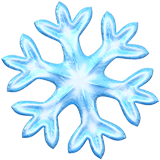

In [2]:
# We will train on a snwoflake emoji
from PIL import Image

image = Image.open('snowflake.png')
display(image)

In [3]:
# Train the model
model = train_loop(image, num_epochs=500)

  0%|          | 0/500 [00:00<?, ?it/s]

Loss 0.04933030903339386: 100%|██████████| 500/500 [01:12<00:00,  6.92it/s] 


<Figure size 640x480 with 0 Axes>

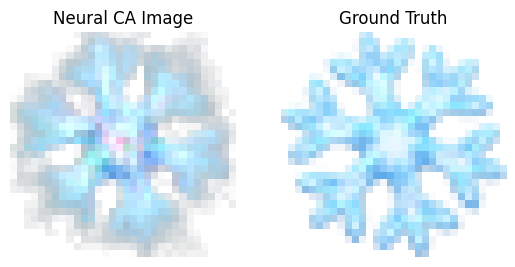

In [4]:
# Initialize the grid
grid = model.initialize_grid()

# Autoregressively do model inference
steps = 64
for step in range(steps):
    grid = model(grid)

# Plot the evolved grid as well as the ground truth
plt.figure()

fig, axs = plt.subplots(ncols=2)

# remove x and y axes when plotting
[ax.set_axis_off() for ax in axs.ravel()]

img = model.grid_to_image(grid)
_ = axs[0].imshow(img)
axs[0].set_title("Neural CA Image")


target_img = model.grid_to_image(model.target)
_ = axs[1].imshow(target_img)
axs[1].set_title("Ground Truth")

plt.show()

In [5]:
from IPython.display import HTML
from matplotlib import animation

def animate_game(n_steps=100):

    grids = []

    def init(grids=grids):
        grid = model.initialize_grid()
        im.set_data(model.grid_to_image(grid))
        grids.append(grid)
        return [im]

    # animation function.  This is called sequentially
    def animate(i, grids=grids):

        if i > 5:
            # skip first frames to show the first grid longer
            grids.append(model(grids[-1]))

        img = model.grid_to_image(grids[-1])

        im.set_array(img)

        return [im]

    # prepare the figures
    fig, ax = plt.subplots(figsize=(4, 4))
    plt.axis('off')

    img = model.grid_to_image(grid)
    im = plt.imshow(img, cmap='gray')

    # call the animator. blit=True means only re-draw the parts that have changed.
    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                    frames=n_steps, interval=64, blit=True)

    plt.close()

    return HTML(anim.to_html5_video())

animate_game()

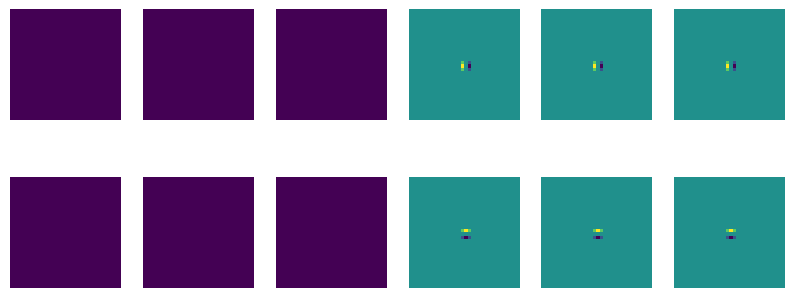

In [6]:
# Sanity check for our sobel filters
# We plot the gradient computation for a newly initialized grid, for which the RGB components are set to 0.

# Initialize the figure
fix, axs = plt.subplots(nrows = 2, ncols = 6, figsize=(10, 4))
[ax.set_axis_off() for ax in axs.ravel()] # remove x and y axes when plotting


init_grid = model.initialize_grid()  # Start with a fresh grid
out_x = model.sobel_x_conv(init_grid)
out_y = model.sobel_y_conv(init_grid)
for idx in range(6):
    # plt.figure()
    axs[0, idx].imshow(out_x[idx, :, :])
    axs[1, idx].imshow(out_y[idx, :, :])